使用scikit-learn的iris数据做样本，取其中2类进行SVM二分类，为了方便出图，事先使用PCA将数据维度降为2维：

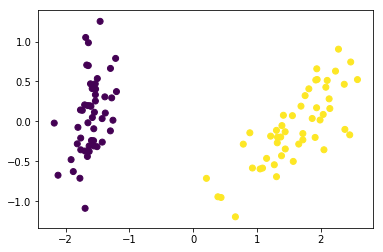

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

iris = datasets.load_iris()
X = iris.data
y = iris.target
X_new = []
y_new = []
for i in range(y.shape[0]):
    if y[i] == 2:
        continue
    elif y[i] == 0:
        y[i] = -1
    X_new.append(X[i])
    y_new.append(y[i])
        
X = np.array(X_new)
y = np.array(y_new)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1], c=y)
plt.show()

#### SVM目标函数推导

SVM优化目标为，令$\xi_i = max(0, 1-y_i(w^Tx_i+b))$：

$$min\frac{\|w\|^2}{2} + C\sum \limits_{i=1}^m \xi_i$$
$$s.t. \ y_i(w^Tx_i+b) \geq 1-\xi_i$$
$$\xi_i \geq 0$$

使用拉格朗日乘子法，令$\alpha_i>0$，$\mu_i>0$

$$L(w,b,\alpha,\mu,\xi) = \frac{\|w\|^2}{2} + C\sum \limits_{i=1}^m \xi_i - \sum \limits_{i=1}^m \alpha_i[y_i(w^Tx_i+b) - 1+\xi_i] - \sum \limits_{i=1}^m \mu_i\xi_i$$

先令L求w、b和$\xi$的偏导等于0，得：

$$ w = \sum \limits_{i=1}^m \alpha_ix_iy_i $$
$$ \sum \limits_{i=1}^m \alpha_iy_i = 0 $$
$$ C = \alpha_i + \mu_i $$

将以上三式代入L，得到原目标函数的对偶问题：

$$ max \sum \limits_{i=1}^m \alpha_i-\frac{1}{2} \sum \limits_{i=1}^m \sum \limits_{j=1}^m \alpha_i\alpha_jy_iy_jx_i^Tx_j$$
$$ s.t. 0 \leq \alpha_i \leq C$$
$$ \sum \limits_{i=1}^m \alpha_iy_i = 0 $$

要求使原目标函数取最小值w、b和$\xi$，可以求满足KTT条件的对偶问题取最大值时的$\alpha$，$ w = \sum \limits_{i=1}^m \alpha_ix_iy_i $，代入$ w^Tx+b = 0 $ 得 $\sum \limits_{i=1}^m \alpha_iy_ix_i^T x +b $。其中KKT条件为：

$$\alpha_i \geq 0$$
$$\mu_i \geq 0$$
$$\xi_i \geq 0$$
$$y_i(w^Tx_i+b) - 1+\xi_i \geq 0$$
$$\alpha_i[y_i(w^Tx_i+b) - 1+\xi_i]=0$$
$$\mu_i\xi_i=0$$

这个复杂的问题需要使用SMO算法来解。

#### SMO算法

SMO的一次迭代选择一对($\alpha_i, \alpha_j$)进行优化，将其它$\alpha$看做常数。拿($\alpha_1, \alpha_2$)为例，经过[漫长痛苦的推导步骤](https://zhuanlan.zhihu.com/p/29212107)，可以得到$\alpha_1$、$\alpha_2$以及$b$的更新公式。

$$\alpha_2^{new} = \alpha_2^{old} + \frac{y_2(E_1-E_2)}{\eta}$$
$$\alpha_1^{new} = \alpha_1^{old} + y_1y_2(\alpha_2^{old}-\alpha_2^{new})$$
其中：$$\eta = K_{11}+K{22}-2K{12}$$
$$E_i = \sum \limits_{k=1}^m \alpha_ky_kx_k^T x_i +b - y_i$$

迭代至$\alpha_1$、$\alpha_2$稳定为止，再选取下一对($\alpha_i, \alpha_j$)进行迭代。参照[The Simplified SMO Algorithm](http://cs229.stanford.edu/materials/smo.pdf)简单地实现smo算法：

In [91]:
def f_xi(X, y, alpha, b, i):
    w = np.zeros(X.shape[1])
    for i in range(X.shape[0]):
        w = w + alpha[i]*y[i]*X[i]
    return w@X[i]+b

import random
def random_j(low, high, i):
    j = random.randint(low, high)
    if j == i:
        return random_j(low, high, i)
    else:
        return j

def rbf(xi, xj):
    return xi.T@xj
#     tmp = xi-xj
#     return np.exp(-1*tmp.T@tmp/2)

def calculate_eta(X, i, j):
    # K11+K22-2K12
    kii = rbf(X[i], X[i])
    kjj = rbf(X[j], X[j])
    kij = rbf(X[i],X[j])
    return kii+kjj-2*kij

def clip_alpha(low, high, alpha):
    if alpha>high:
        return high
    if alpha<low:
        return low
    return alpha
    
def simplified_smo(X, y, tol, c, max_passes):
    alpha = np.zeros(X.shape[0])
    b = 0
    passes = 0
    while (passes<max_passes):
        num_changed_alpha = 0
        for i in range(alpha.shape[0]):
            error_i = f_xi(X, y, alpha, b, i) - y[i]
            
            alpha_i = alpha[i]
            
            if not ((alpha_i>0 and y[i]*error_i>tol)
                or (alpha_i<c and y[i]*error_i<-1*tol)):
                #KKT 
                continue
            
#             import pdb;pdb.set_trace()
            j = random_j(0, alpha.shape[0]-1, i)
            alpha_j = alpha[j]
            error_j = f_xi(X, y, alpha, b, j) - y[j]
            
            alpha_i_old = alpha_i
            alpha_j_old = alpha_j
            
            low = 0
            high = 0
            if y[i] != y[j]:
                low = max(0, alpha_j - alpha_i)
                high = min(c, c+alpha_j-alpha_i)
            else:
                low = max(0, alpha_j + alpha_i - c)
                high = min(c, alpha_j+alpha_i)
                
            if low == high:
                # this j will be i in other step of this loop
                continue
            
            eta = calculate_eta(X, i, j)
            if eta==0:
                continue;
            
            alpha_j = alpha_j+(y[j]*(error_i-error_j))/eta
            alpha_j = clip_alpha(low, high, alpha_j)
            
            alpha[j]=alpha_j
            if abs(alpha_j-alpha_j_old)<10e-5:
                continue;
            
            alpha_i = alpha_i+y[i]*y[j]*(alpha_j_old-alpha_j)
            alpha[i] = alpha_i
            
            bi = b-error_i-y[i]*(alpha_i-alpha_i_old)*rbf(X[i],X[i])-y[j]*(alpha_j-alpha_j_old)*rbf(X[i],X[j])
            bj = b-error_j-y[i]*(alpha_i-alpha_i_old)*rbf(X[i],X[j])-y[j]*(alpha_j-alpha_j_old)*rbf(X[j],X[j])
            if alpha_i>0 and alpha_i<c:
                b =bi
            elif alpha_j>0 and alpha_j<c:
                b =bj
            else:
                b =(bi+bj)/2
            num_changed_alpha=num_changed_alpha+1
        
        if num_changed_alpha==0:
            passes = passes+1
        else:
            passes = 0
    
    return (alpha, b)

In [92]:
# from sklearn.gaussian_process.kernels import RBF

# rbf = RBF()
# X = rbf(X)

(alpha, b) = simplified_smo(X, y, 1e-4, 1, 1000)

In [93]:
w = np.zeros(X.shape[1])
for i in range(X.shape[0]):
    w = w + alpha[i]*y[i]*X[i]

In [94]:
x1 = np.linspace(-2,2,100)
x2 = (-1*b-w[0]*x1)/w[1]

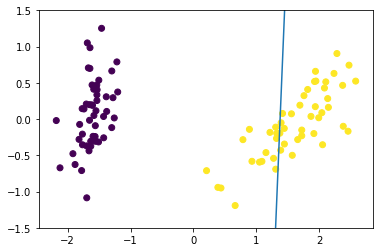

In [95]:
fig, ax = plt.subplots()
ax.plot(x1, x2)
ax.scatter(X[:,0], X[:,1], c=y)
ax.set_ylim([-1.5, 1.5])
plt.show()